# Radar Data Streaming and Pre-Processing

### This notebook demonstrates how to read the data from the radar using python wrapper for Infineon Radar SDK

#### Importing required libraries 

    - ifxdaq --> is the python wrapper for Radar SDK
    - processing --> is python module for basic processing to get the phase information from the radar signal
    

In [1]:
import ifxdaq
import processing
import numpy as np
from fft import range_doppler_fft
#print(ifxdaq.__version__)
from ifxdaq.sensor.radar_ifx import RadarIfxAvian
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from numpy import savetxt
from sklearn import svm
import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import pandas as pd
import seaborn
import sklearn
from sklearn.preprocessing import StandardScaler 
import warnings
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import model_from_json
from scipy import signal
from scipy.signal import find_peaks
warnings.filterwarnings('ignore')

In [15]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'ifxdaq',
 'processing',
 'numpy',
 'matplotlib.pyplot',
 'sklearn.svm',
 'scipy',
 'sklearn.metrics',
 'pandas',
 'seaborn',
 'sklearn',
 'warnings',
 'tensorflow',
 'pickle',
 'scipy.signal',
 'types',
 'pkg_resources']

#### In the folder 'radar_configs' you find radar configuration parameters. It contains radar parameters :

    - transmit power level
    - start/end frequency
    - sampling rate
    - # of chirps per frame
    - # of samples per chirp
    - # of transmit/receive antennas
    - MIMO mode selection

In [2]:
config_file = "radar_configs/RadarIfxBGT60.json"
raw_data = []

#### the next code block initiliaze the radar with set configuration and loop through the continuous frames; when it  reaches 5000 frames which is 5 second data according to our set configuration, we process it to get the phase information out of it.

In [3]:
def fetch_data(time_ms):
    raw_data    = []
    with RadarIfxAvian(config_file) as device:                             # Initialize the radar with configurations
        for i_frame, frame in enumerate(device):                           # Loop through the frames coming from the radar
            raw_data.append(np.squeeze(frame['radar'].data/(4095.0)))      # Dividing by 4095.0 to scale the data
            
            if(len(raw_data) > time_ms-1 and len(raw_data) % time_ms == 0):        # 5000 is the number of frames. which corresponds to 5seconds
                data = np.swapaxes(np.asarray(raw_data), 0, 1)
                
                phases, abses, centers, radii = processing.do_processing(data)       # preprocessing to get the phase information
                phases              = np.mean(phases, axis=0)
                
                range_idx, range_data = processing.processing_rangeData(data)
                break
                
    return phases, abses, data, raw_data, range_data, range_idx*7.5, centers, radii

In [4]:
def loading_model_parameters():
    # loading the trained model standard scaler parameters
    scaler = pickle.load(open('scaler.pkl','rb'))    

    # loading the trained model PCA parameters
    pca = pickle.load(open('pca_req.pkl','rb'))      

    # loading the ann model parameters
    file = open('model.json', 'r')
    loaded  = file.read()
    file.close()
    ann_model = model_from_json(loaded)
    ann_model.load_weights("model.h5")

    # loading the radar configurations
    config_file = "radar_configs/RadarIfxBGT60.json"

    return scaler, pca, ann_model


In [5]:
def detect_state(phases_data):
    '''checking the state of the person : Anxious and Rest'''
    sc,pc,ann_model = loading_model_parameters()
    scaled_data = sc.transform(np.atleast_2d(phases_data)) #.T
    test_pca = pc.transform(scaled_data)
    y_pred=ann_model.predict(test_pca)

    if(y_pred>=0.5):
        print("Anxious")
    else:
        print("Rest")

    return None

In [6]:
def get_vitals(phases_data):
    displacement = (0.005/(4*np.pi))*phases_data

  # band pass filter for breathrate
    sos_b = signal.butter(6, (0.2/500,0.5/500), 'band', fs=1, output='sos')
    filtered_b = signal.sosfilt(sos_b, displacement)
    plt.xlabel('Time (ms)')
    plt.ylabel('Disturbance (Zero Mean)')
    plt.title("Breathing Rate")
    plt.plot(filtered_b)
    plt.show()
    peaks_b,_= find_peaks(filtered_b, prominence=(0.0005, None))
    numpeaks_b=len(peaks_b)
    breathrate=numpeaks_b*6

  # band pass filter for heartrate
    sos_h = signal.butter(6, (0.5/500,2/500), 'band', fs=1, output='sos')
    filtered_h = signal.sosfilt(sos_h, displacement)
    plt.xlabel('Time (ms)')
    plt.ylabel('Disturbance (Zero Mean)')
    plt.title("Heart Rate")
    plt.plot(filtered_h)
    plt.show()
    peaks_h,_= find_peaks(filtered_h, prominence=(0.00020,None))
    numpeaks_h=len(peaks_h)
    heartrate=numpeaks_h*6
  
    return breathrate, heartrate

In [7]:
'''
file_name_1 = 'stationary.csv'
file_name_2 = 'moving.csv'
stationary_data = genfromtxt(file_name_1, delimiter=',')
moving_data = genfromtxt(file_name_2, delimiter=',')

train_x = np.concatenate((stationary_data, moving_data), axis =0)
train_y = np.ravel(np.concatenate((np.full((120,1),0), np.full((120,1),1)) , axis=0))

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.15) # 85% training and 15% test

clf = svm.SVC(kernel='linear', degree=6)
clf.fit(x_train, y_train)

filename = 'SVM.sav'
pickle.dump(clf, open(filename, 'wb'))

svm_result = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, svm_result))
'''

'\nfile_name_1 = \'stationary.csv\'\nfile_name_2 = \'moving.csv\'\nstationary_data = genfromtxt(file_name_1, delimiter=\',\')\nmoving_data = genfromtxt(file_name_2, delimiter=\',\')\n\ntrain_x = np.concatenate((stationary_data, moving_data), axis =0)\ntrain_y = np.ravel(np.concatenate((np.full((120,1),0), np.full((120,1),1)) , axis=0))\n\nx_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.15) # 85% training and 15% test\n\nclf = svm.SVC(kernel=\'linear\', degree=6)\nclf.fit(x_train, y_train)\n\nfilename = \'SVM.sav\'\npickle.dump(clf, open(filename, \'wb\'))\n\nsvm_result = clf.predict(x_test)\nprint("Accuracy:",metrics.accuracy_score(y_test, svm_result))\n'

In [8]:
#Movement Detection
global phases, heart_rate, breathing_rate
heart_rate = 0
breathing_rate = 0
def motion_detection():
    global phases
    phases, abses, data, raw_data, range_data, range_idx, centers, radii = fetch_data(10000) #5000
    
    x_rdi = range_doppler_fft(data[:,:5000,:])
    temp_1 = np.sum(np.abs(np.mean(x_rdi,axis=0)), axis=1)
    temp_1 = np.atleast_2d(temp_1)
    temp_2 = np.atleast_2d(range_idx)
    test_data = np.concatenate((temp_1,temp_2),axis=1)
    #svm_result = clf.predict(test_data)
    loaded_svm_model = pickle.load(open('SVM.sav' , 'rb'))
    svm_result = loaded_svm_model.predict(test_data)
    threshold = 2500 
    plt.xlabel('Time (ms)')
    plt.ylabel('Velocity Disturbance (Zero Mean)')
    plt.title("Doppler FFT")
    plt.plot(np.mean(x_rdi,axis=0))
    plt.show()
    temp = np.mean(np.mean(x_rdi,axis=0), axis=1)
    magnitude = np.linalg.norm(temp)
    area_threshold = 1500
    centers_threshold = 1500
    no_of_circles = len(radii)
    area_array = np.zeros((no_of_circles,1))
    i = 0
    for items in radii:  
        area_array[i] = np.pi * items**2
        i = i+1
    circle_area_deviation = np.std(area_array)
    circle_centers_deviation = np.std(centers)
    deviation_threshold = 160
    if (np.std(temp_1) < deviation_threshold and svm_result == 0 and magnitude < threshold and circle_area_deviation < area_threshold and circle_centers_deviation < centers_threshold):
        return False
    else:
        return True

In [9]:
#Band Pass Filter for Heart Rate
global low_pass_HR, high_pass_HR
low_pass_HR = 0.8
high_pass_HR = 2
def heart_rate_signal(phases, low_pass_HR, high_pass_HR):
    sos = scipy.signal.butter(6, [low_pass_HR/500, high_pass_HR/500], 'band', fs=1, output='sos')
    filtered_HR = scipy.signal.sosfilt(sos,phases) 
    heart_rate_peaks, _ = scipy.signal.find_peaks(filtered_HR, prominence=[0.05,None]) #Peak Count for Heart Rate Calculation
    return len(heart_rate_peaks)*60/5

global low_pass_BR, high_pass_BR
low_pass_BR = 0.2
high_pass_BR = 0.5
def breathing_rate_signal(phases, low_pass_BR, high_pass_BR):
    #Band Pass Filter for Breathing Rate
    sos = scipy.signal.butter(6, [low_pass_BR/500, high_pass_BR/500], 'band', fs=1, output='sos')
    filtered_BR = scipy.signal.sosfilt(sos,phases)
    breathing_rate_peaks, _ = scipy.signal.find_peaks(filtered_BR, prominence=[0.0005,None]) #Peak Count for Breathing Rate Calculation
    return len(breathing_rate_peaks)*60/5

Note: There is a function to get range_data called "processing_rangeData" which will be usefull to detect the movements.

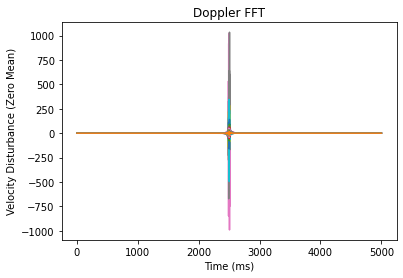

Too Much Movement Detected. Measurement occurs only in Quasistatic State
Vital Readings will be inaccurate


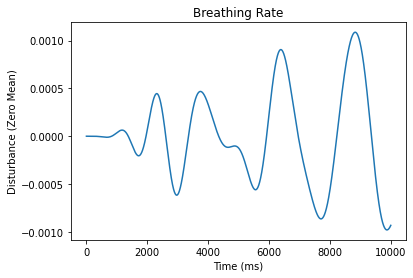

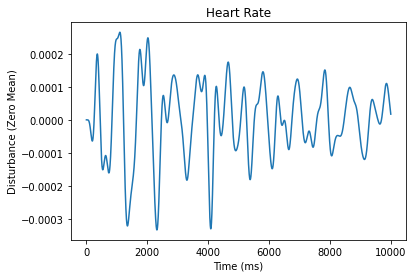

Heart Rate 60
Breath Rate 24
Rest


Failed to get frame from radar device. (Retry 1/3)
Failed to get frame from radar device. (Retry 2/3)
Failed to get frame from radar device. (Retry 3/3)


TimeoutError: Failed to get frame from radar device.

In [12]:
#Kalman Filter State Estimation (Heart Rate)
''' 
global prev_heart_rate_estimate
prev_heart_rate_estimate = 0
def read_sensor():
    global prev_heart_rate_estimate
    heart_rate_estimate = heart_rate_signal(phases, low_pass_HR, high_pass_HR)
    estim_error_sq = (heart_rate_estimate - prev_heart_rate_estimate)**2
    prev_heart_rate_estimate = heart_rate_estimate
    return heart_rate_estimate, estim_error_sq

def ellipsoidal_gating(z,y,P):
    gating_threshold_low = [[210]]
    gating_threshold_high = [[350]]
    if gating_threshold_low < np.linalg.det((z-y) * np.linalg.inv(P) * (z-y)) < gating_threshold_high :
        return True
    else:
        return False

def update_bandpass_HR(x,P):
    low_pass_HR = x[1] - P[0,0]**0.5
    high_pass_HR = x[1] + P[0,0]**0.5
    return None
    ''' 
''' 
d_t = 5
const_accel_process_noise_var = 0.13
f = KalmanFilter (dim_x=3, dim_z=1)
f.x = np.array([80., 0., 0.])                  #State: heart rate in Hertz, its first-order derivative, and second-order derivative
f.F = np.array([[1.,d_t, 0.5*d_t**2],
                [0.,1., d_t],
                [0.,0.,1.]])                  #State Transtion Matrix
f.H = np.array([[1.,0., 0.]])                 #Measurement Matrix
f.P = np.array([[1000.,    0., 0.],
                [   0., 1000., 0.],
               [ 0., 0., 1000.]])             #Covariance Matrix
f.R = np.array([[50.]])                       #Measurement Noise
f.Q = Q_discrete_white_noise(dim=3, dt=d_t, var=const_accel_process_noise_var)
''' 
while True:
    check_movement = motion_detection()
    if check_movement == True:
        print('Too Much Movement Detected. Measurement occurs only in Quasistatic State')
        print('Vital Readings will be inaccurate')
    else:
        print('Quasi-Static State Detected, Proceeding with Measurement')
    
    breathrate, heartrate = get_vitals(phases)
    print('Heart Rate', heartrate)
    print('Breath Rate', breathrate)
    '''
    f.z, f.h = read_sensor()
    f.predict()
    f.y = f.H @ f.x 
    check_quality = ellipsoidal_gating(f.z, f.y, f.P)
    if check_quality == True:
        f.x = f.update(f.z)
        update_bandpass_HR(f.x,f.P)
        
     '''   
    detect_state(phases)